In [7]:
import sys
import glob
import yaml
import pyart
import joblib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.spatial.distance as dst
from matplotlib.colors import LinearSegmentedColormap

sys.path.append('../scripts')
import core
from calculate_distances import bname

In [2]:
win=100
nbasis=15
exp = 'nat8b'
dataset = 'cohort'

stim_info = pd.read_csv(f"../inputs/stimuli/{exp}-info.csv")
spectrograms = pd.read_csv(f"../build/{exp}/spectrograms.csv", index_col=[0,1])
motifs = stim_info.motif.unique()
gaps = stim_info[stim_info.type=='G'].groupby(['motif','gap']).first()[['gap_start', 'gap_stop']]
gaplocs = gaps.index.levels[1].to_numpy().astype(int)
dsetdata = []
for h5file in glob.glob(f"../build/{exp}/**_delemb_win{win}_basis{nbasis}.h5"):
    dsetdata.append(pd.read_hdf(h5file, key='Induction'))
responses = pd.concat(dsetdata, axis=1)
models = joblib.load(f"../output/{exp}/{dataset}_PLS_models.pkl")
model = models['all']

In [5]:
projections = []
for m in motifs:
    cstim = spectrograms.loc[bname(m, 'C', None)]
    for g in gaplocs:
        ga, gb = gaps.loc[m].loc[g].astype(int)
        for c in ['C','G','CB', 'GB', 'N', 'GM', 'CM']:
            stim = bname(m, c, g)
            X = model.transform(
                X = responses.loc[stim].loc[ga:gb]
            )
            projections.append({
                'motif': m,
                'gap': g,
                'condition': c,
                'projections': X
            })
result = pd.DataFrame(projections).set_index(['motif', 'gap', 'condition'])

### Rank projections by location

In [8]:
distmap = []
for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
    CI_proj = result.loc[m, g, 'C'].projections[:,:3]
    CI_dist = [dst.euclidean(x, [1,-1,-2]) for x in CI_proj]
    distmap.append({
        'motif':m,
        'gap':g,
        'avg': np.mean(CI_dist)
    })
distmap = pd.DataFrame(distmap).sort_values('avg')
distmap['distrank'] = np.arange(16)
distmap['viridiscolor'] = [mpl.colormaps['viridis'](x) for x in np.linspace(0,1,16)]
distmap.set_index(['motif','gap'], inplace=True)
distmap.head()

avg  distrank                         viridiscolor
motif   gap                                                         
nat8mk2 2    2.001998         0  (0.267004, 0.004874, 0.329415, 1.0)
nat8mk3 1    2.033600         1   (0.282656, 0.100196, 0.42216, 1.0)
nat8mk4 1    2.077981         2  (0.277134, 0.185228, 0.489898, 1.0)
nat8mk5 1    2.168951         3  (0.253935, 0.265254, 0.529983, 1.0)
        2    2.173140         4  (0.221989, 0.339161, 0.548752, 1.0)

## Unified latent space projections

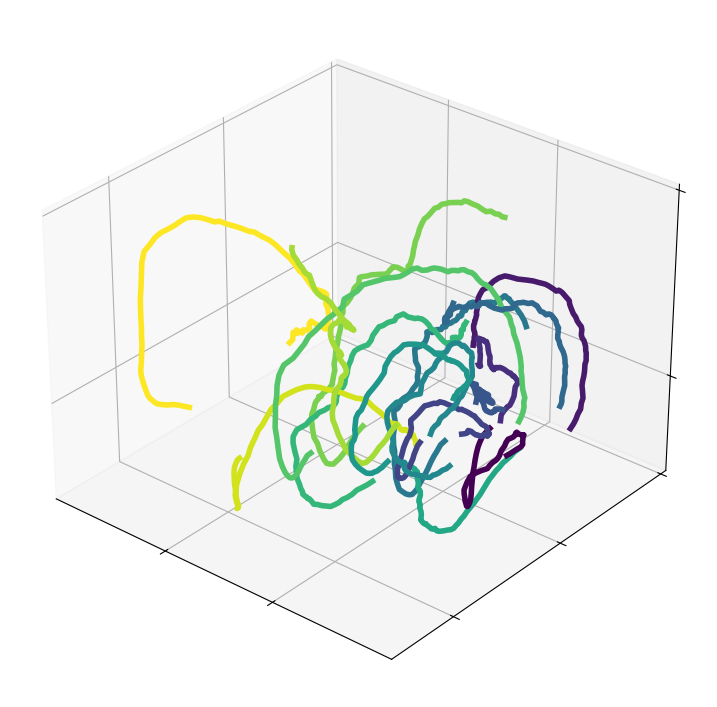

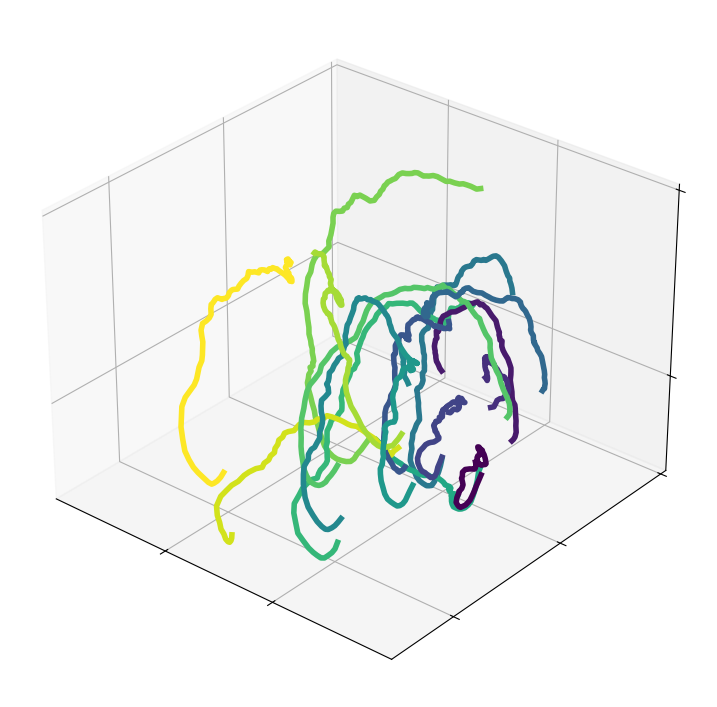

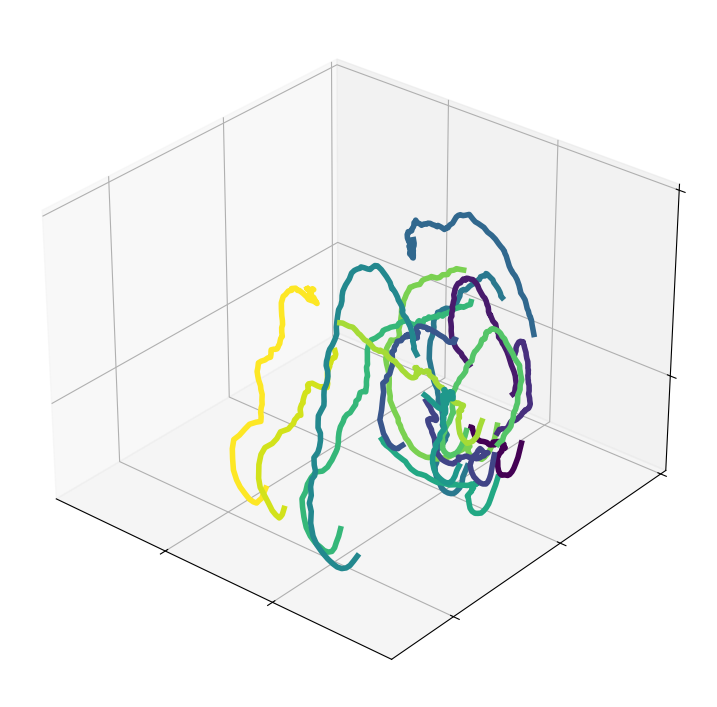

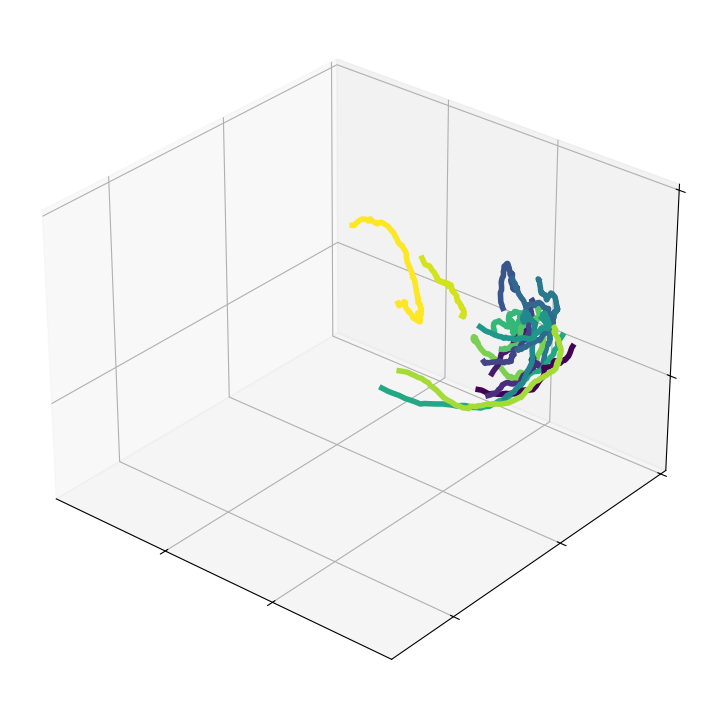

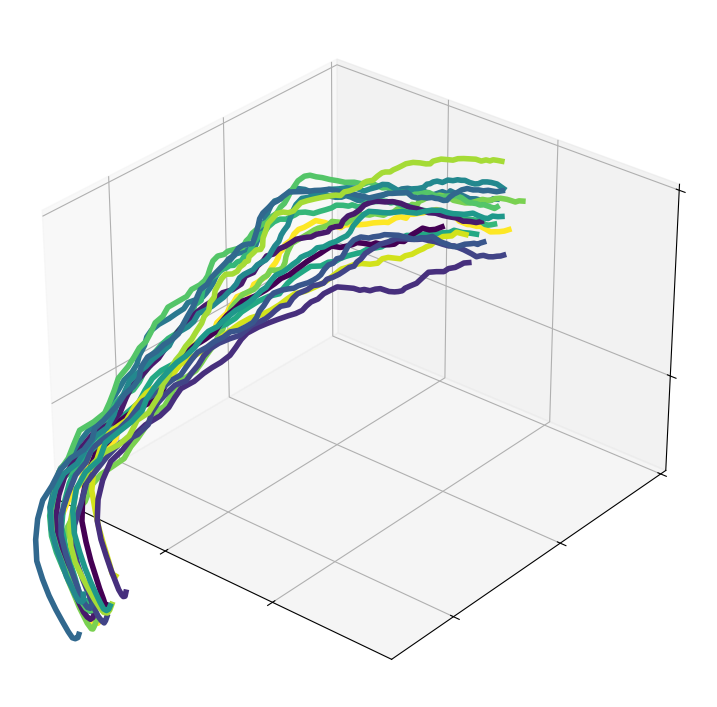

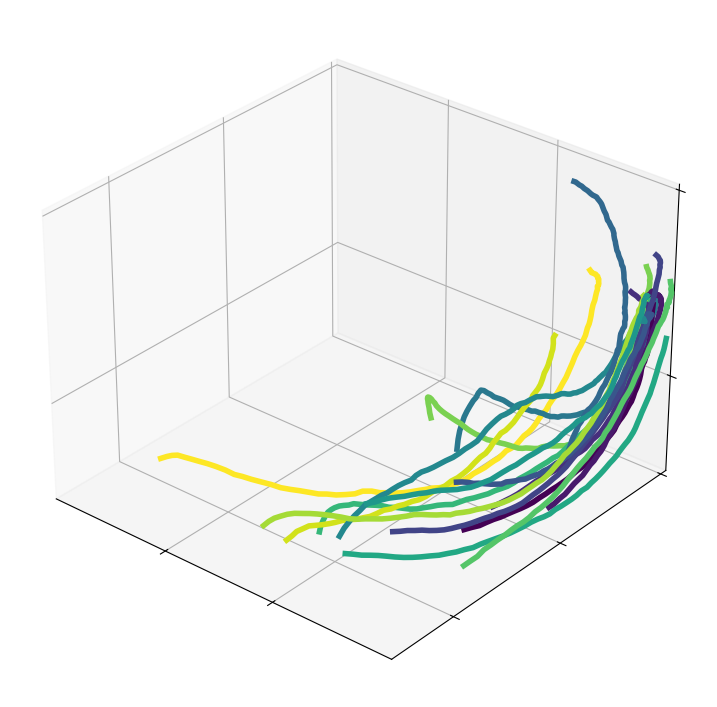

In [10]:
colbar = False
for c in ['C','CB','GB','GM','N','G']:
    fig = plt.figure(figsize=(10,9))
    ax = fig.add_subplot(1,9,(2,9),projection='3d')
    plt.setp(ax.spines.values(), lw=3, color='black')
    for i, (m, g) in enumerate(itertools.product(motifs, gaplocs)):
        projs = result.loc[m, g, c].projections
        img = ax.plot(
            projs[:, 0],
            projs[:, 1],
            projs[:, 2],
            alpha=1,
            color= distmap.loc[m,g].viridiscolor,
            lw=4
        )
    ax.view_init(elev=30, azim=130, roll=0)
    ax.set_xlim(1,4)
    ax.set_xticks([2,3], [])
    ax.set_ylim(-1,1.5)
    ax.set_yticks([-1,0,1], [])
    ax.set_zlim(-1.5,0)
    ax.set_zticks([-1,0], [])
    ax.set_title(c)
    if colbar:
        clbax = fig.add_subplot(1,9,1)
        gradient = np.linspace(0,1,16)
        gradient = np.vstack((gradient, gradient))
        clbax.imshow(gradient.T, cmap=cm, aspect=2)
        clbax.set_xticks([])
        clbax.set_yticks([])

In [11]:
def heatmap(data, x='GB', y='CB', centered=False, init=False):
    matrix = []
    for (m1, g1), mgdata1 in data.groupby(level=['motif', 'gap']):
        for (m2, g2), mgdata2 in data.groupby(level=['motif', 'gap']):
            proj_from = mgdata1.loc[m1, g1, x].projections
            proj_to = mgdata2.loc[m2, g2, y].projections
            distances = np.array([dst.euclidean(
                proj_from[t, :],
                proj_to[t, :]
            ) for t in np.arange(min(proj_from.shape[0], proj_to.shape[0]))])
            matrix.append({
                'from_m': m1,
                'from_g': g1,
                'to_m': m2,
                'to_g': g2,
                'dist': distances[0] if init else distances.mean()
            })
    heatmatrix = pd.DataFrame(matrix).set_index(['from_m', 'from_g', 'to_m', 'to_g']).unstack(['to_m', 'to_g'])
    return heatmatrix

In [12]:
GBC = heatmap(result, 'GB', 'C', centered=False)

In [13]:
GBCB = heatmap(result, 'GB', 'CB', centered=False)

In [14]:
GBGB = heatmap(result, 'GB', 'GB', centered=False)

In [15]:
GBGM = heatmap(result, 'GB', 'GM', centered=False)

In [16]:
GMGM = heatmap(result, 'GM', 'GM', centered=False)

In [17]:
sns.set_style('white')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 2

plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 2

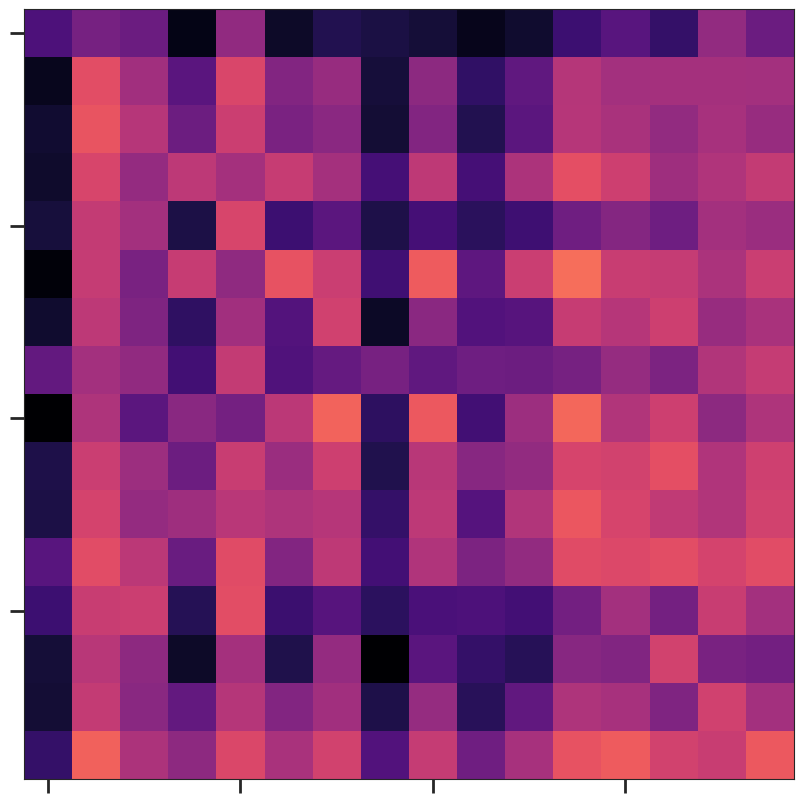

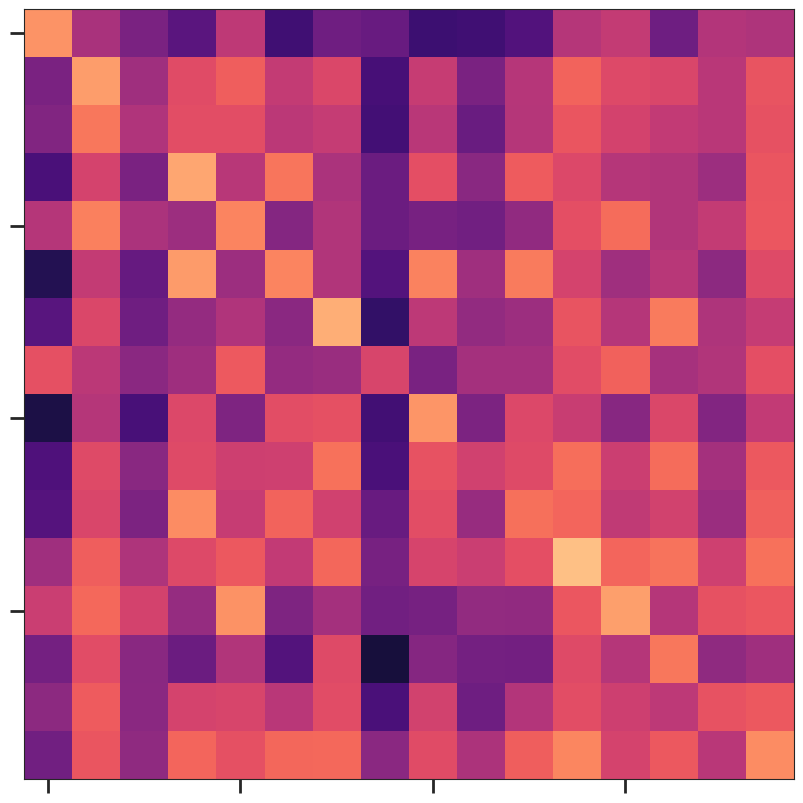

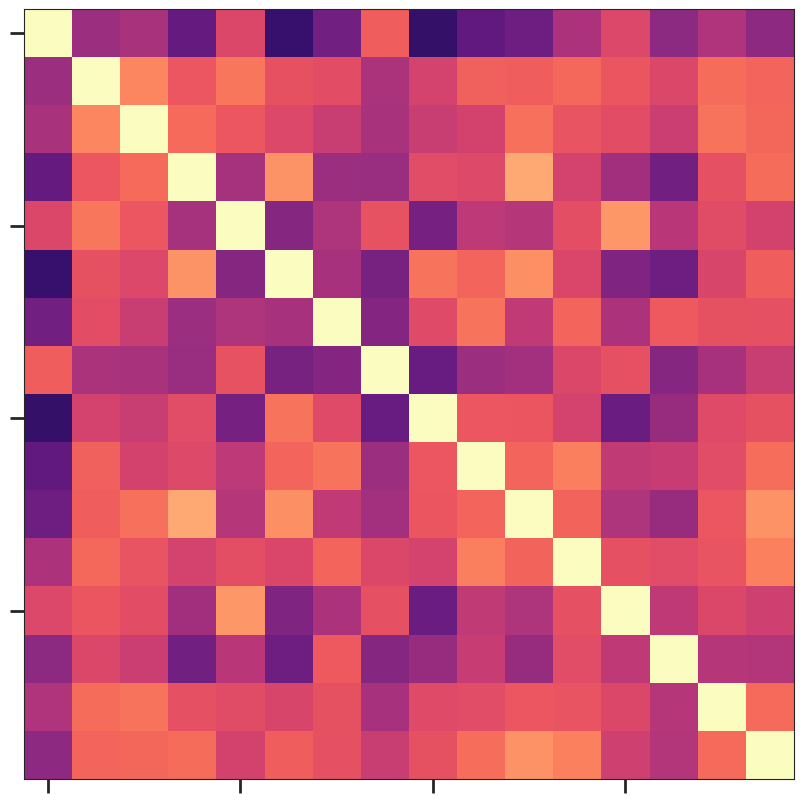

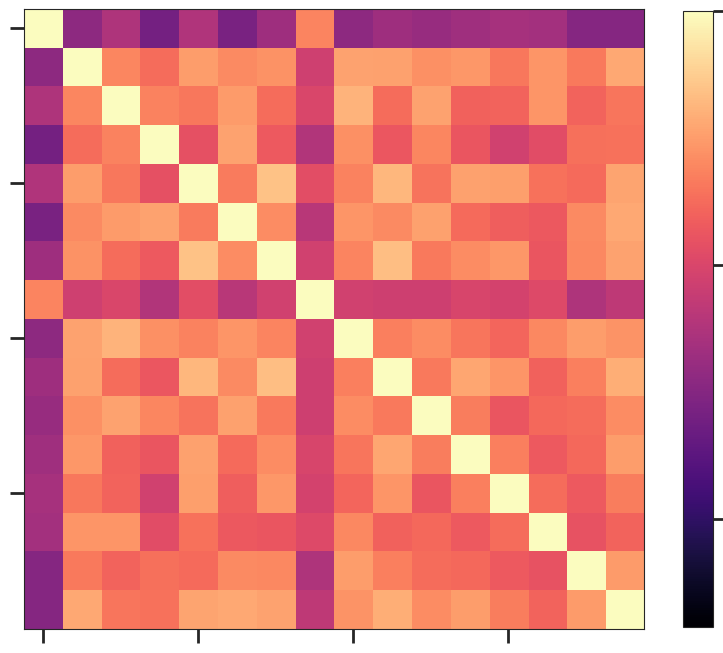

In [18]:
heatmax = np.max([
    GBC.max(axis=None),
    GBCB.max(axis=None),
    GBGB.max(axis=None),
    GBGM.max(axis=None),
])
heatmin = np.min([
    GBC.min(axis=None),
    GBCB.min(axis=None),
    GBGB.min(axis=None),
    GBGM.min(axis=None),
])
for matrix in [GBC, GBCB, GBGB, GMGM]:
    ax = plt.figure(figsize=(10,10)).add_subplot()
    img = ax.imshow(matrix*-1, vmin=heatmax*-1, vmax=heatmin*-1, cmap='magma')
    ax.set_xticks(np.arange(0,16,4), [])
    ax.set_yticks(np.arange(0,16,4), [])
cbar = plt.colorbar(img,
                    ticks=[0,-1,-2],
                    format=mpl.ticker.FixedFormatter(['','','']),
                    shrink=0.8)

In [19]:
R_export1 = GBCB.stack([1,2], future_stack=True).reset_index(drop=False)#.apply()
R_export1['same_CI'] = R_export1.apply(
    lambda row: (row.from_m==row.to_m)&(row.from_g==row.to_g),
    axis=1)
R_export1['exp'] = 'nat8b'
R_export1['GB_to'] = 'CB'

R_export2 = GBC.stack([1,2], future_stack=True).reset_index(drop=False)#.apply()
R_export2['same_CI'] = R_export2.apply(
    lambda row: (row.from_m==row.to_m)&(row.from_g==row.to_g),
    axis=1)
R_export2['exp'] = 'nat8b'
R_export2['GB_to'] = 'C'

pd.concat([R_export1, R_export2]).to_csv('../output/pairwise-nat8b-unified.csv')

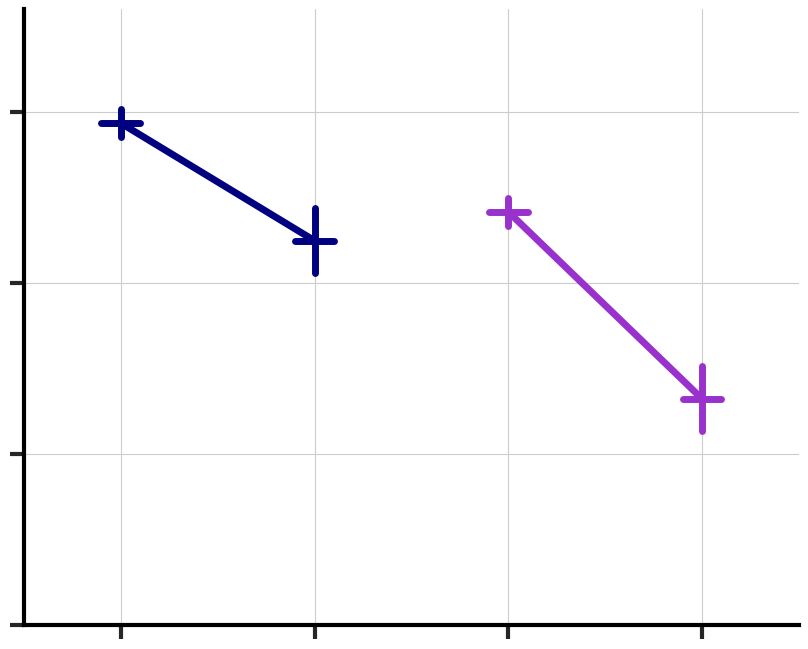

In [44]:
Rresult = pd.read_csv("../output/Rmodel-nat8b-unified.csv", index_col=[0]).set_index(
    ['same_CI', 'GB_to']
)
ax = plt.figure(figsize=(10,8)).add_subplot()

for ti, GB_to in enumerate(['C','CB']):
    color = colors[GB_to] 
    ax.plot(
        [ti*2, ti*2+1],
        [Rresult.loc[False, GB_to].emmean, Rresult.loc[True, GB_to].emmean],
        color=color, lw=5
    )
    for si, same_CI in enumerate([False, True]):
        i1 = Rresult.loc[same_CI, GB_to].emmean - Rresult.loc[same_CI, GB_to].SE
        i2 = Rresult.loc[same_CI, GB_to].emmean + Rresult.loc[same_CI, GB_to].SE
        ax.plot(
            [si+ti*2,si+ti*2],  [i1, i2],
            color=color, lw=5
        )
        ax.plot(
            [si+ti]
        )
        ax.plot(
            [si+ti*2-0.1, si+ti*2+0.1],
            [Rresult.loc[same_CI, GB_to].emmean, Rresult.loc[same_CI, GB_to].emmean],
            color=color, lw=5
        )
        ax.set_ylim(0,1.8)
        ax.set_xlim(-0.5,3.5)
        ax.set_xticks([0,1,2,3],[])
        ax.set_yticks([0,0.5,1,1.5], [])
        plt.setp(ax.spines.values(), lw=3, color='black')
        sns.despine(ax=ax, top=True, right=True)